In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math
import pickle
import os
from datetime import datetime
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create directories to store models and results
model_dir = 'drive/MyDrive/Colab Notebooks/models'
results_dir = 'drive/MyDrive/Colab Notebooks/results'

os.makedirs(model_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# Define headers for the dataset
header = [
    "timestamp",
    "cpu_usage",
    "top_1_cpu_proc_name",
    "top_1_cpu_proc_usage",
    "top_2_cpu_proc_name",
    "top_2_cpu_proc_usage",
    "top_3_cpu_proc_name",
    "top_3_cpu_proc_usage",
    "top_4_cpu_proc_name",
    "top_4_cpu_proc_usage",
    "top_5_cpu_proc_name",
    "top_5_cpu_proc_usage",
    "mem_usage",
    "top_1_mem_proc_name",
    "top_1_mem_proc_usage",
    "top_2_mem_proc_name",
    "top_2_mem_proc_usage",
    "top_3_mem_proc_name",
    "top_3_mem_proc_usage",
    "top_4_mem_proc_name",
    "top_4_mem_proc_usage",
    "top_5_mem_proc_name",
    "top_5_mem_proc_usage",
    "nginx_active_connections",
    "nginx_rps"
]

Mounted at /content/drive


In [2]:
def load_and_preprocess_data(filepath, seq_length=10):
    """
    Load and preprocess the system stats data

    Parameters:
    - filepath: Path to the CSV file
    - seq_length: Sequence length for LSTM data preparation

    Returns:
    - Dictionary containing preprocessed data and objects
    """
    # Load the dataset with semicolon separator and defined headers
    df = pd.read_csv(filepath, sep=';', names=header, header=None)

    # Convert timestamp to datetime using ISO8601 format to handle various timestamp formats
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')

    print(f"Dataset shape: {df.shape}")
    print(f"First 5 rows of the dataset:")
    display(df.head())

    # Extract numerical columns for modeling
    numerical_columns = [
        'cpu_usage', 'top_1_cpu_proc_usage', 'top_2_cpu_proc_usage',
        'top_3_cpu_proc_usage', 'top_4_cpu_proc_usage', 'top_5_cpu_proc_usage',
        'mem_usage', 'top_1_mem_proc_usage', 'top_2_mem_proc_usage',
        'top_3_mem_proc_usage', 'top_4_mem_proc_usage', 'top_5_mem_proc_usage',
        'nginx_active_connections', 'nginx_rps'
    ]

    # Extract time-based features
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

    # Add time features to numerical columns
    numerical_columns += ['hour', 'day_of_week', 'is_weekend']

    # Get only numerical data for analysis
    numerical_df = df[numerical_columns]

    # Check for missing values
    print("\nMissing values in numerical columns:")
    display(numerical_df.isnull().sum())

    # Fill missing values if any
    if numerical_df.isnull().any().any():
        print("Filling missing values with column means...")
        numerical_df = numerical_df.fillna(numerical_df.mean())

    # Normalize the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(numerical_df)
    scaled_df = pd.DataFrame(scaled_data, columns=numerical_df.columns)

    # Split data into training and testing sets (80/20)
    train_data, test_data = train_test_split(scaled_df, test_size=0.2, shuffle=False)

    print(f"Training data shape: {train_data.shape}")
    print(f"Testing data shape: {test_data.shape}")

    return {
        'df': df,
        'numerical_df': numerical_df,
        'scaled_df': scaled_df,
        'train_data': train_data,
        'test_data': test_data,
        'scaler': scaler,
        'numerical_columns': numerical_columns
    }

# Load and preprocess the data
data_dict = load_and_preprocess_data('drive/MyDrive/Colab Notebooks/dataset/system_stats.csv')

# Save the scaler
with open(f'{model_dir}/scaler.pkl', 'wb') as f:
    pickle.dump(data_dict['scaler'], f)


Dataset shape: (189381, 25)
First 5 rows of the dataset:


,timestamp,cpu_usage,top_1_cpu_proc_name,top_1_cpu_proc_usage,top_2_cpu_proc_name,top_2_cpu_proc_usage,top_3_cpu_proc_name,top_3_cpu_proc_usage,top_4_cpu_proc_name,top_4_cpu_proc_usage,...,top_2_mem_proc_name,top_2_mem_proc_usage,top_3_mem_proc_name,top_3_mem_proc_usage,top_4_mem_proc_name,top_4_mem_proc_usage,top_5_mem_proc_name,top_5_mem_proc_usage,nginx_active_connections,nginx_rps
0,2025-02-12 10:57:02.564357,2.5,python3 /etc/zabbix/templates/host_anomaly_det...,32.3,/usr/lib/systemd/systemd --system --deserializ...,0.0,kthreadd,0.0,kworker/0:0H,0.0,...,/usr/sbin/mysqld --basedir=/usr,11.21,/usr/sbin/named -u named -c /etc/named.conf,2.46,/usr/sbin/amavisd (master),1.58,/usr/sbin/amavisd (virgin child),1.57,14,0.53
1,2025-02-12 10:57:17.641898,1.3,python3 /etc/zabbix/templates/host_anomaly_det...,27.9,/usr/lib/systemd/systemd --system --deserializ...,0.0,kthreadd,0.0,kworker/0:0H,0.0,...,/usr/sbin/mysqld --basedir=/usr,11.21,/usr/sbin/named -u named -c /etc/named.conf,2.46,/usr/sbin/amavisd (master),1.58,/usr/sbin/amavisd (virgin child),1.57,22,1.19
2,2025-02-12 10:57:32.616511,5.0,python3 /etc/zabbix/templates/host_anomaly_det...,39.1,rcu_sched,7.6,/usr/lib/systemd/systemd --system --deserializ...,0.0,kthreadd,0.0,...,/usr/sbin/mysqld --basedir=/usr,11.21,/usr/sbin/named -u named -c /etc/named.conf,2.46,/usr/sbin/amavisd (master),1.58,/usr/sbin/amavisd (virgin child),1.57,27,1.47
3,2025-02-12 10:57:47.734987,0.0,python3 /etc/zabbix/templates/host_anomaly_det...,22.2,/usr/lib/systemd/systemd --system --deserializ...,0.0,kthreadd,0.0,kworker/0:0H,0.0,...,/usr/sbin/mysqld --basedir=/usr,11.21,/usr/sbin/named -u named -c /etc/named.conf,2.46,/usr/sbin/amavisd (master),1.58,/usr/sbin/amavisd (virgin child),1.57,27,0.66
4,2025-02-12 10:58:02.571353,0.0,python3 /etc/zabbix/templates/host_anomaly_det...,38.3,/usr/lib/systemd/systemd --system --deserializ...,0.0,kthreadd,0.0,kworker/0:0H,0.0,...,/usr/sbin/mysqld --basedir=/usr,11.21,/usr/sbin/named -u named -c /etc/named.conf,2.46,/usr/sbin/amavisd (master),1.58,/usr/sbin/amavisd (virgin child),1.57,28,0.20



Missing values in numerical columns:


,0
cpu_usage,0
top_1_cpu_proc_usage,0
top_2_cpu_proc_usage,0
top_3_cpu_proc_usage,0
top_4_cpu_proc_usage,0
top_5_cpu_proc_usage,0
mem_usage,0
top_1_mem_proc_usage,0
top_2_mem_proc_usage,0
top_3_mem_proc_usage,0


Training data shape: (151504, 17)
Testing data shape: (37877, 17)


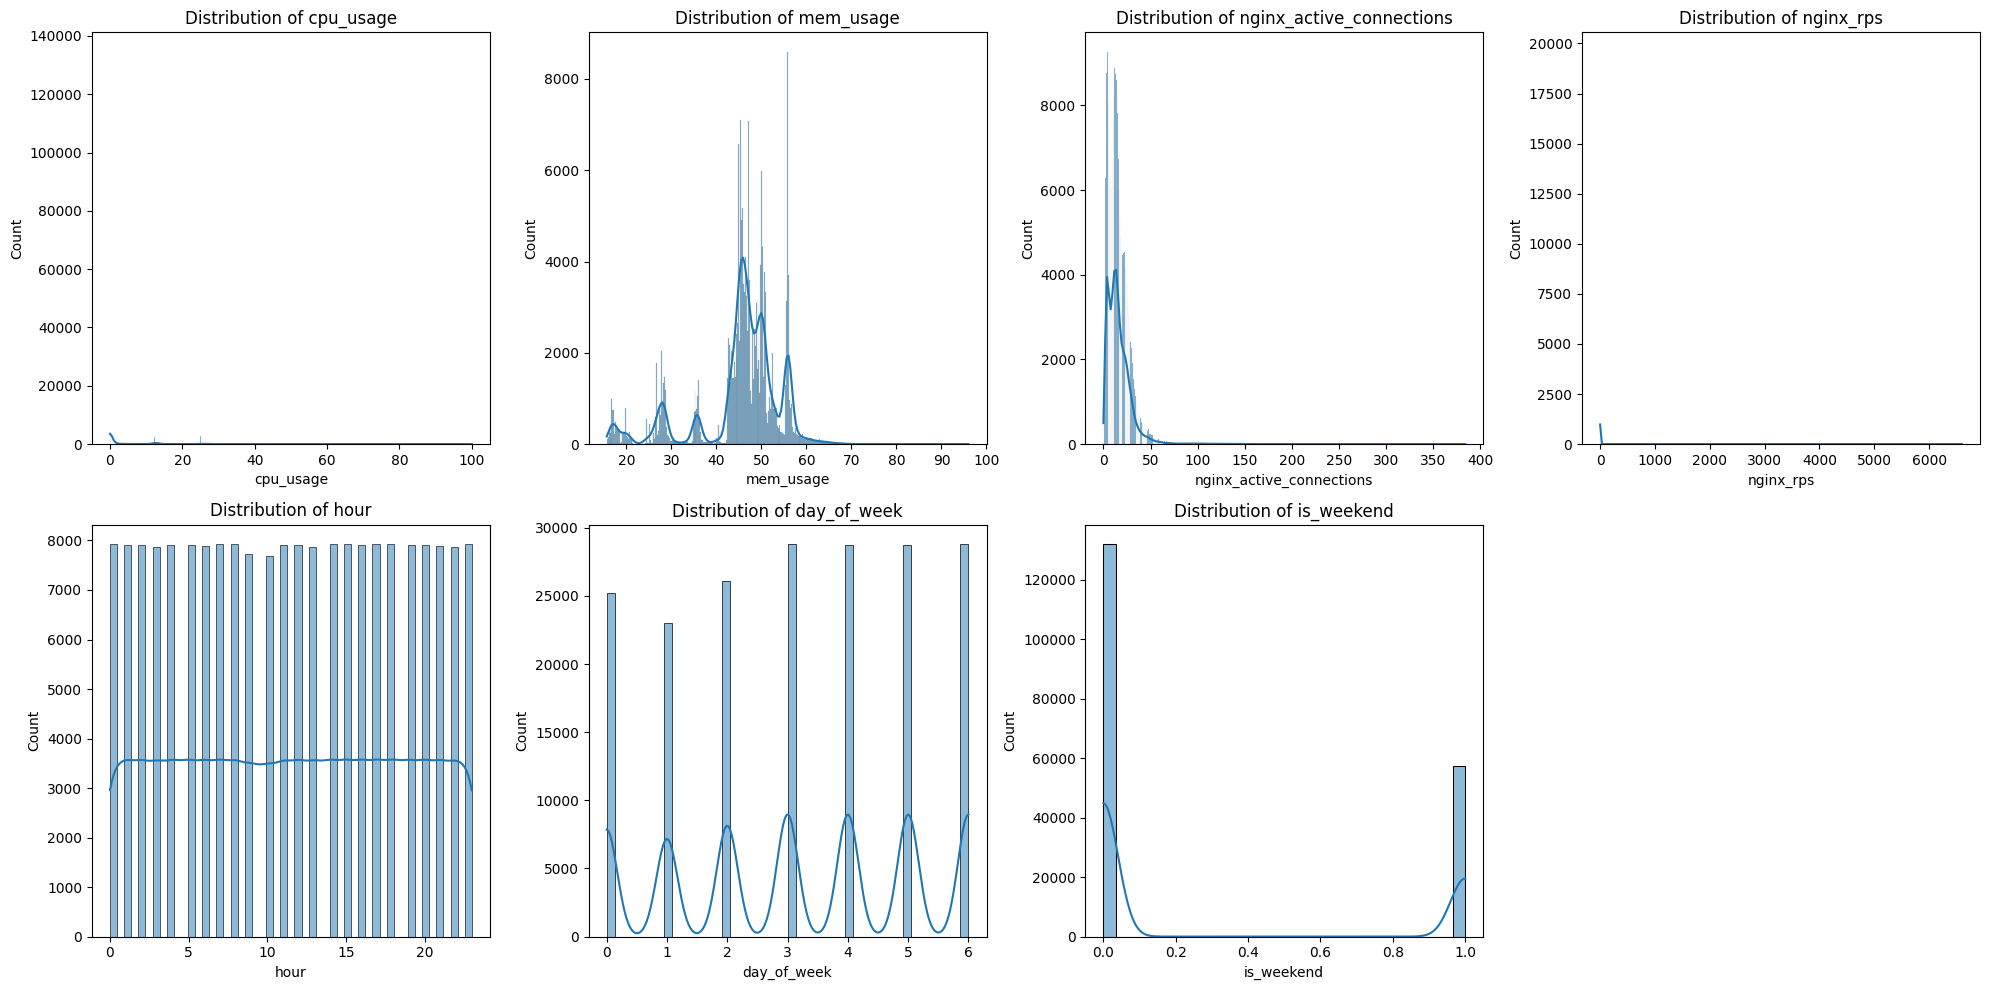

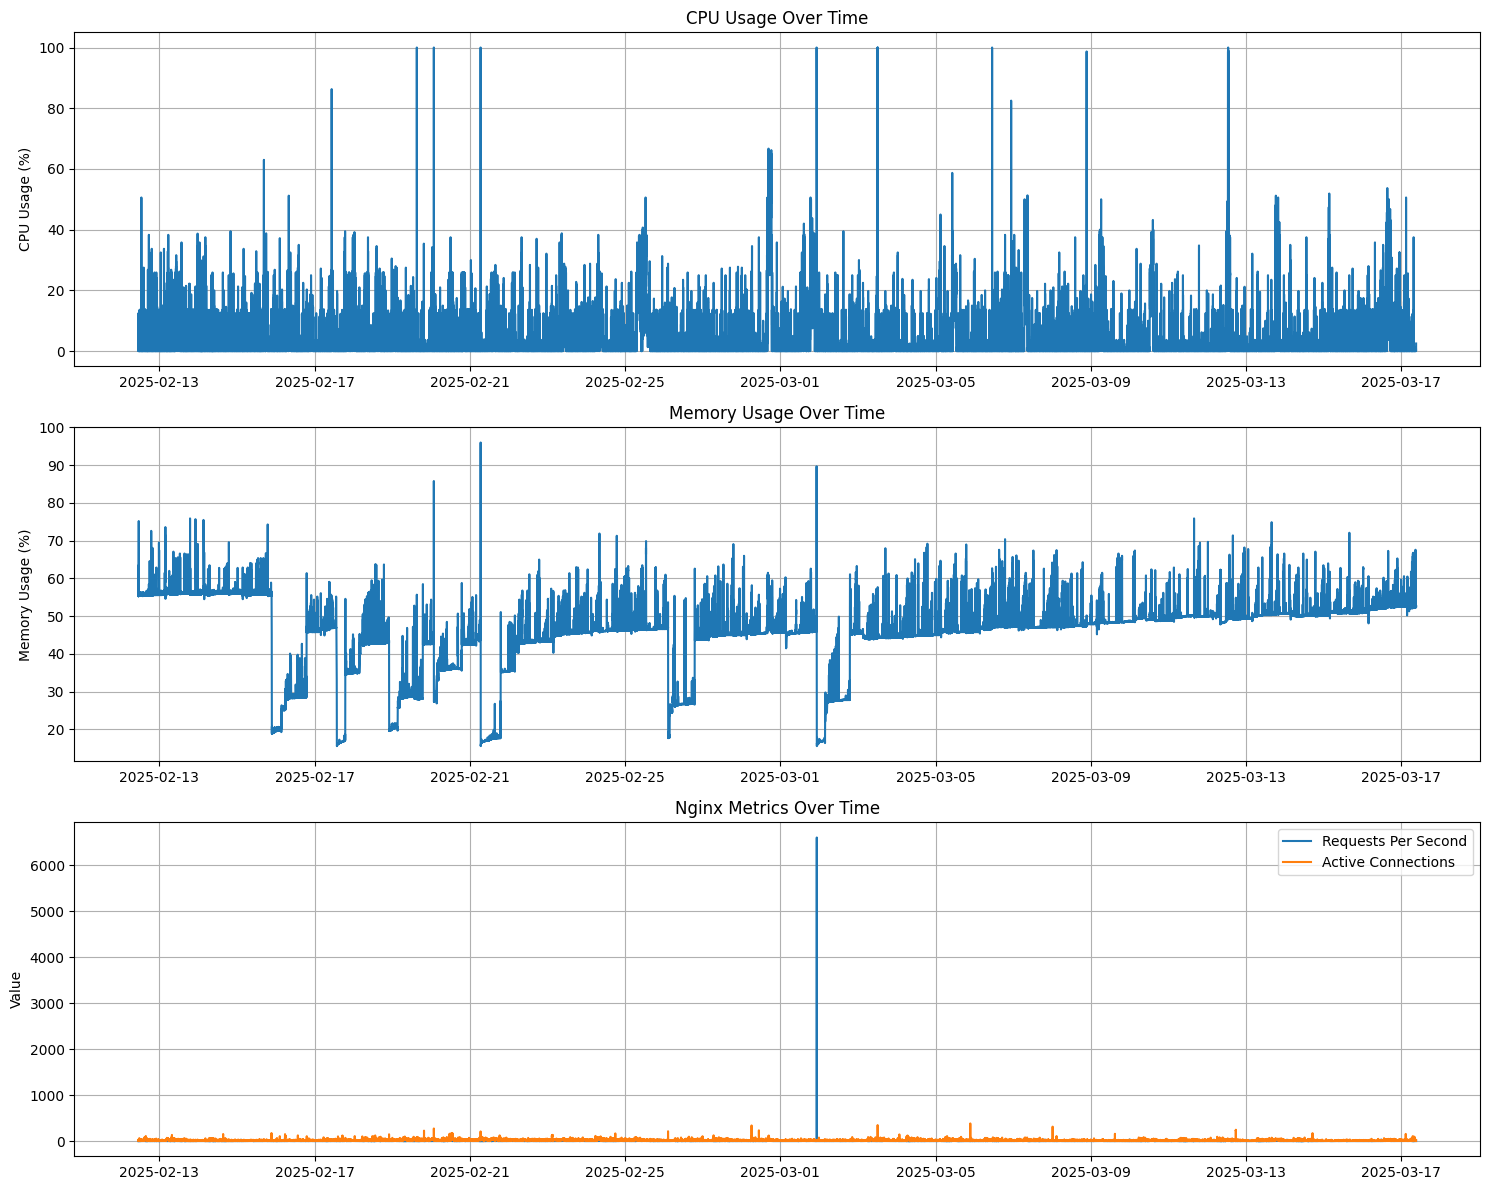

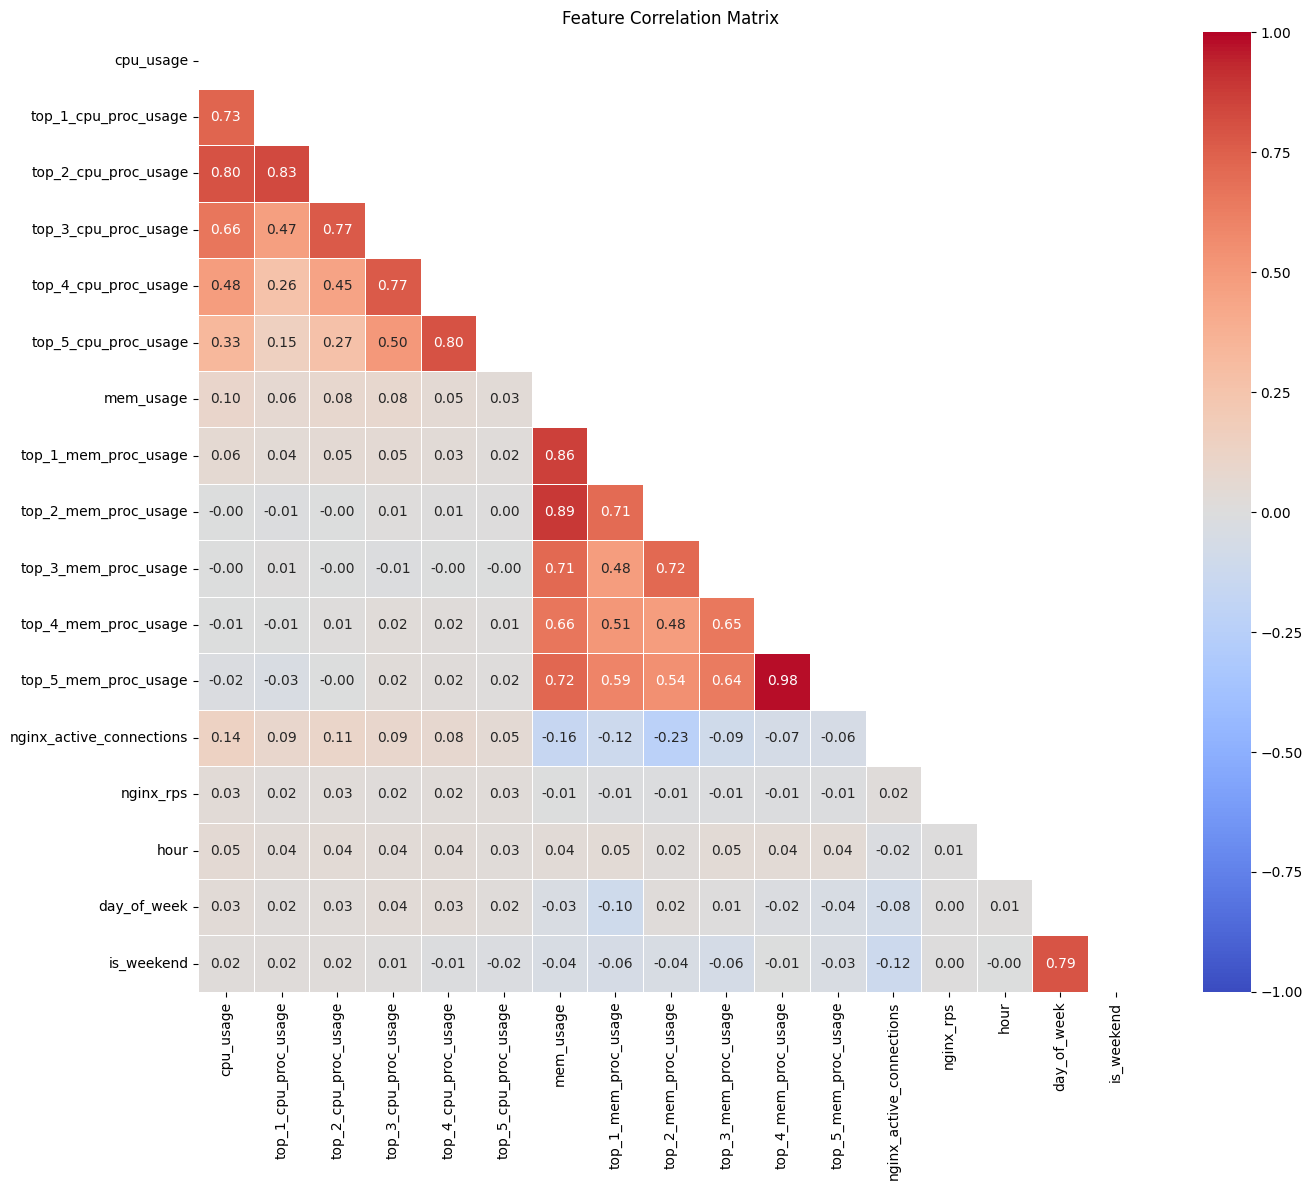

In [3]:
def visualize_data_distributions(numerical_df, columns=None):
    """
    Visualize the distribution of numerical features

    Parameters:
    - numerical_df: DataFrame containing numerical features
    - columns: List of columns to visualize. If None, use all columns.
    """
    if columns is None:
        columns = numerical_df.columns

    n_features = len(columns)
    n_cols = 4
    n_rows = (n_features + n_cols - 1) // n_cols

    plt.figure(figsize=(20, 5 * n_rows))
    for i, feature in enumerate(columns):
        plt.subplot(n_rows, n_cols, i+1)
        sns.histplot(numerical_df[feature], kde=True)
        plt.title(f'Distribution of {feature}')
    plt.tight_layout()
    plt.savefig(f'{results_dir}/feature_distributions.png')
    plt.show()

def visualize_time_series(df, numerical_columns):
    """
    Visualize key metrics over time

    Parameters:
    - df: Original DataFrame with timestamp
    - numerical_columns: List of numerical columns
    """
    # Select key metrics
    key_metrics = ['cpu_usage', 'mem_usage', 'nginx_active_connections', 'nginx_rps']

    plt.figure(figsize=(15, 12))

    plt.subplot(3, 1, 1)
    plt.plot(df['timestamp'], df['cpu_usage'])
    plt.title('CPU Usage Over Time')
    plt.ylabel('CPU Usage (%)')
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(df['timestamp'], df['mem_usage'])
    plt.title('Memory Usage Over Time')
    plt.ylabel('Memory Usage (%)')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(df['timestamp'], df['nginx_rps'], label='Requests Per Second')
    plt.plot(df['timestamp'], df['nginx_active_connections'], label='Active Connections')
    plt.title('Nginx Metrics Over Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'{results_dir}/time_series.png')
    plt.show()

def plot_correlation_matrix(numerical_df):
    """
    Plot correlation matrix for numerical features

    Parameters:
    - numerical_df: DataFrame containing numerical features
    """
    plt.figure(figsize=(14, 12))
    corr = numerical_df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm',
                vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig(f'{results_dir}/correlation_matrix.png')
    plt.show()

# Visualize data
visualize_data_distributions(data_dict['numerical_df'],
                            columns=['cpu_usage', 'mem_usage', 'nginx_active_connections',
                                    'nginx_rps', 'hour', 'day_of_week', 'is_weekend'])
visualize_time_series(data_dict['df'], data_dict['numerical_columns'])
plot_correlation_matrix(data_dict['numerical_df'])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 17)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 12)                  │             216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │              45 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │              25 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 12)                  │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 17)                  │             221 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 791 (3.09 KB)

 Trainable params: 791 (3.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 0.0373 - val_loss: 0.0108
Epoch 2/50
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 0.0115 - val_loss: 0.0106
Epoch 3/50
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0111 - val_loss: 0.0106
Epoch 4/50
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0106 - val_loss: 0.0095
Epoch 5/50
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0096 - val_loss: 0.0097
Epoch 6/50
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0092 - val_loss: 0.0096
Epoch 7/50
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.0090 - val_loss: 0.0092
Epoch 8/50
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.0074 - val_loss: 0.0041
Epoch 9/50
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 10/50
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 11/50
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 12/50
4735/47

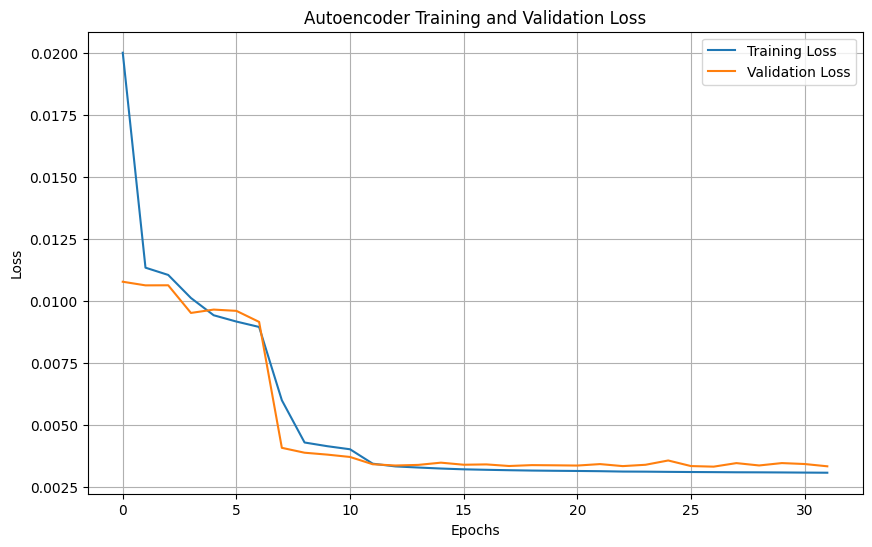

1184/1184 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Autoencoder Evaluation Metrics:
Mean Absolute Error (MAE): 0.0233
Mean Squared Error (MSE): 0.0033
Root Mean Squared Error (RMSE): 0.0576


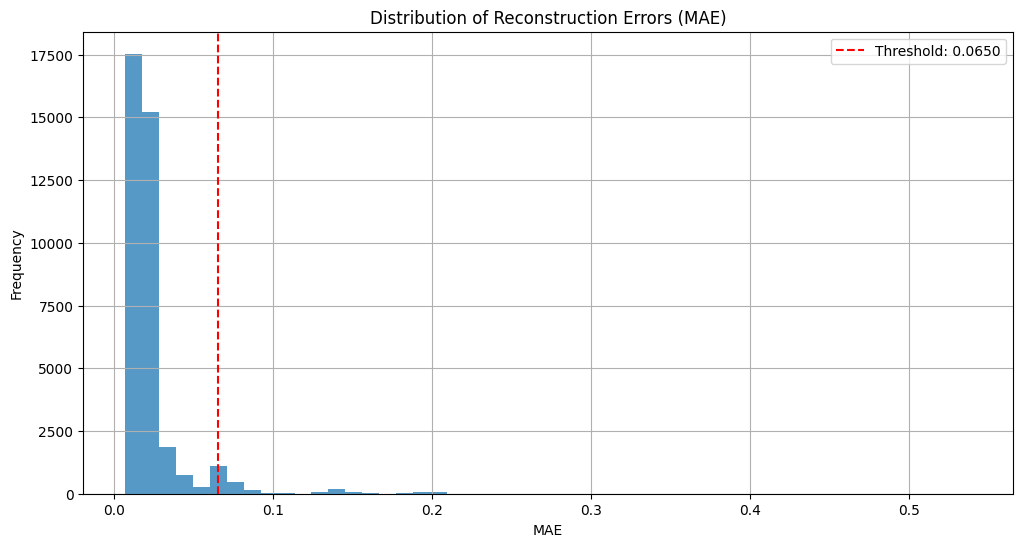

Number of anomalies detected: 1894
Percentage of anomalies: 5.00%


In [4]:
def build_autoencoder(input_dim):
    """
    Build an autoencoder model for anomaly detection

    Parameters:
    - input_dim: Dimension of input features

    Returns:
    - Compiled autoencoder model
    """
    # Encoder
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(int(input_dim * 0.75), activation="relu")(input_layer)
    encoder = Dense(int(input_dim * 0.5), activation="relu")(encoder)
    encoder = Dense(int(input_dim * 0.33), activation="relu")(encoder)

    # Bottleneck layer
    bottleneck = Dense(int(input_dim * 0.25), activation="relu")(encoder)

    # Decoder
    decoder = Dense(int(input_dim * 0.33), activation="relu")(bottleneck)
    decoder = Dense(int(input_dim * 0.5), activation="relu")(decoder)
    decoder = Dense(int(input_dim * 0.75), activation="relu")(decoder)
    output_layer = Dense(input_dim, activation="sigmoid")(decoder)

    # Create the autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    return autoencoder

def train_and_evaluate_autoencoder(train_data, test_data):
    """
    Train and evaluate an autoencoder model

    Parameters:
    - train_data: Training data (normalized)
    - test_data: Test data (normalized)

    Returns:
    - Dictionary containing model, threshold, and anomalies
    """
    input_dim = train_data.shape[1]

    # Build the autoencoder
    autoencoder = build_autoencoder(input_dim)
    autoencoder.summary()

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Train the autoencoder
    history = autoencoder.fit(
        train_data, train_data,
        epochs=50,
        batch_size=32,
        validation_data=(test_data, test_data),
        callbacks=[early_stopping],
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Autoencoder Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{results_dir}/autoencoder_training.png')
    plt.show()

    # Make predictions on test data
    test_pred = autoencoder.predict(test_data)

    # Calculate reconstruction errors
    test_mae = np.mean(np.abs(test_data.values - test_pred), axis=1)
    test_mse = np.mean(np.square(test_data.values - test_pred), axis=1)
    test_rmse = np.sqrt(test_mse)

    # Calculate overall metrics
    overall_mae = mean_absolute_error(test_data, test_pred)
    overall_mse = mean_squared_error(test_data, test_pred)
    overall_rmse = math.sqrt(overall_mse)

    print(f"Autoencoder Evaluation Metrics:")
    print(f"Mean Absolute Error (MAE): {overall_mae:.4f}")
    print(f"Mean Squared Error (MSE): {overall_mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {overall_rmse:.4f}")

    # Visualize reconstruction error distribution
    plt.figure(figsize=(12, 6))
    plt.hist(test_mae, bins=50, alpha=0.75)

    # Set anomaly threshold (95th percentile of reconstruction error)
    threshold = np.percentile(test_mae, 95)
    plt.axvline(x=threshold, color='r', linestyle='--',
                label=f'Threshold: {threshold:.4f}')

    plt.title('Distribution of Reconstruction Errors (MAE)')
    plt.xlabel('MAE')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{results_dir}/reconstruction_error_distribution.png')
    plt.show()

    # Flag anomalies
    anomalies = test_mae > threshold
    print(f"Number of anomalies detected: {np.sum(anomalies)}")
    print(f"Percentage of anomalies: {np.sum(anomalies) / len(test_mae) * 100:.2f}%")

    # Save model and threshold
    autoencoder.save(f'{model_dir}/autoencoder_model.h5')
    np.save(f'{model_dir}/anomaly_threshold.npy', threshold)

    return {
        'model': autoencoder,
        'threshold': threshold,
        'test_mae': test_mae,
        'anomalies': anomalies,
        'history': history
    }

# Train and evaluate autoencoder
autoencoder_results = train_and_evaluate_autoencoder(
    data_dict['train_data'],
    data_dict['test_data']
)


LSTM input shape: (37867, 10, 17)
LSTM output shape: (37867,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          20,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,953 (132.63 KB)

 Trainable params: 33,953 (132.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
947/947 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.9444 - loss: 0.1578 - val_accuracy: 0.9650 - val_loss: 0.0838
Epoch 2/50
947/947 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9666 - loss: 0.0763 - val_accuracy: 0.9651 - val_loss: 0.0797
Epoch 3/50
947/947 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9672 - loss: 0.0770 - val_accuracy: 0.9647 - val_loss: 0.0809
Epoch 4/50
947/947 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9679 - loss: 0.0766 - val_accuracy: 0.9651 - val_loss: 0.0789
Epoch 5/50
947/947 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9643 - loss: 0.0807 - val_accuracy: 0.9653 - val_loss: 0.0787
Epoch 6/50
947/947 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9673 - loss: 0.0767 - val_accuracy: 0.9654 - val_loss: 0.0779
Epoch 7/50
947/947 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9674 - loss: 0.0763 - val_accuracy: 0.9654 - val_loss: 0.0790
Epoch 8/50
947/947 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9672 - loss: 0.0763 - 

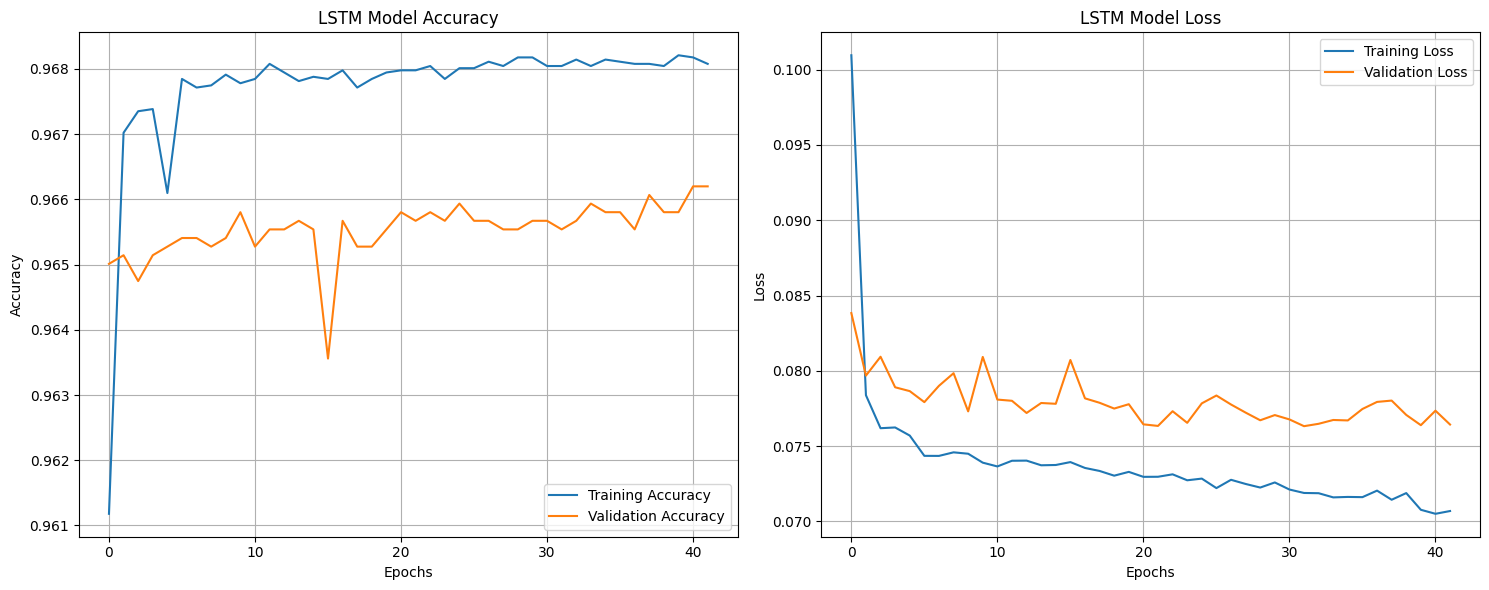

237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
LSTM Model Evaluation Metrics:
Accuracy: 0.9655
Precision: 0.8993
Recall: 0.3526
F1 Score: 0.5066


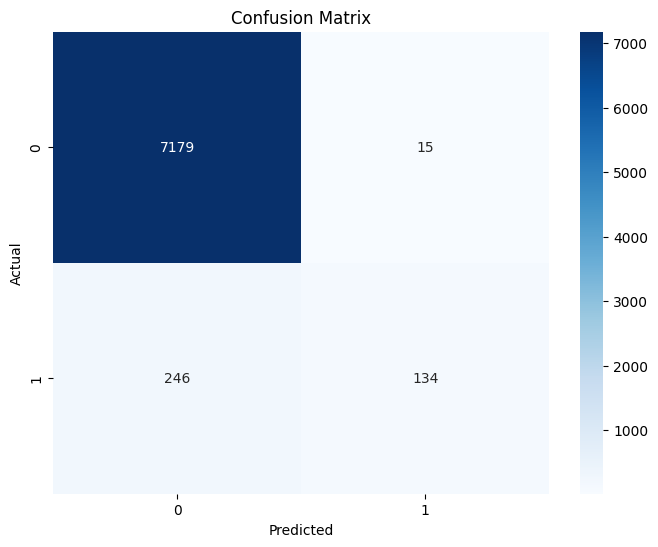

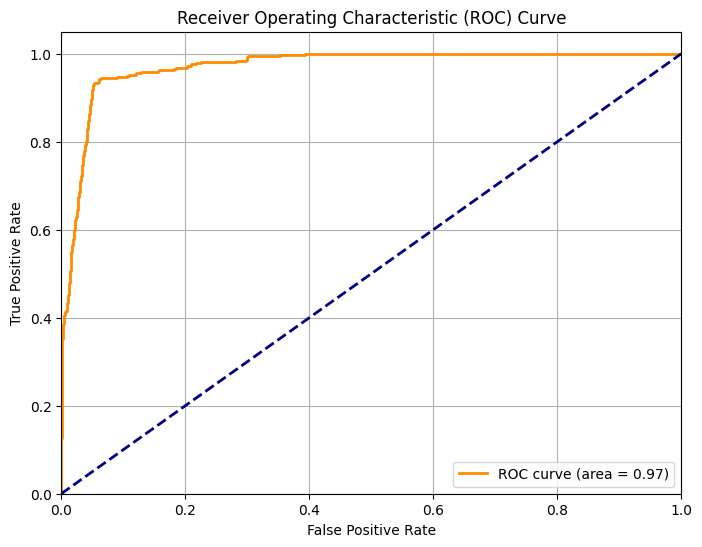

In [5]:
def create_sequences(data, seq_length, labels=None):
    """
    Create sequences for LSTM model

    Parameters:
    - data: DataFrame with features
    - seq_length: Length of sequences
    - labels: Array of labels (optional)

    Returns:
    - X: Sequences
    - y: Labels (if provided)
    """
    xs = []
    ys = []

    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)].values
        xs.append(x)

        if labels is not None:
            y = labels[i + seq_length]
            ys.append(y)

    if labels is not None:
        return np.array(xs), np.array(ys)
    else:
        return np.array(xs)

def build_lstm_model(seq_length, n_features):
    """
    Build LSTM model for anomaly detection

    Parameters:
    - seq_length: Length of input sequences
    - n_features: Number of features

    Returns:
    - Compiled LSTM model
    """
    model = Sequential()
    model.add(LSTM(64, input_shape=(seq_length, n_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def train_and_evaluate_lstm(test_data, anomalies, seq_length=10):
    """
    Train and evaluate LSTM model using anomalies detected by autoencoder

    Parameters:
    - test_data: Test data (normalized)
    - anomalies: Boolean array indicating anomalies from autoencoder
    - seq_length: Length of sequences for LSTM

    Returns:
    - Dictionary containing model and evaluation metrics
    """
    # Convert anomalies to integers
    y_pseudo = anomalies.astype(int)

    # Create sequences for LSTM
    X_seq, y_seq = create_sequences(
        test_data.reset_index(drop=True),
        seq_length,
        y_pseudo
    )

    print(f"LSTM input shape: {X_seq.shape}")
    print(f"LSTM output shape: {y_seq.shape}")

    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_seq, y_seq, test_size=0.2, random_state=42
    )

    # Build and train LSTM model
    lstm_model = build_lstm_model(seq_length, X_train.shape[2])
    lstm_model.summary()

    # Early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Train the model
    history = lstm_model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('LSTM Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'{results_dir}/lstm_training.png')
    plt.show()

    # Evaluate LSTM model
    y_pred_proba = lstm_model.predict(X_val)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)

    print(f"LSTM Model Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'{results_dir}/lstm_confusion_matrix.png')
    plt.show()

    # Plot ROC curve
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(f'{results_dir}/lstm_roc_curve.png')
    plt.show()

    # Save the LSTM model
    lstm_model.save(f'{model_dir}/lstm_model.h5')

    # Save sequence length for future use
    with open(f'{model_dir}/seq_length.txt', 'w') as f:
        f.write(str(seq_length))

    return {
        'model': lstm_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'history': history
    }

# Train and evaluate LSTM
lstm_results = train_and_evaluate_lstm(
    data_dict['test_data'],
    autoencoder_results['anomalies']
)
